<a href="https://colab.research.google.com/github/ryanhantruong/cbis-ddsm-classifier/blob/main/Segmentation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#!pip install -q git+https://github.com/tensorflow/examples.git
#!pip install --upgrade --user tensorflow_datasets
#!git clone https://github.com/matterport/Mask_RCNN.git
#!pip install tensorflow==1.15.0
#!pip install scikit-image==0.16.2
#!pip install keras==2.1.0
!pip install imgaug
#!pip freeze | grep Keras
#!ls -l


     |████████████████████████████████| 948 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 59.2 MB/s eta 0:00:01
     |████████████████████████████████| 51.0 MB 98.6 MB/s eta 0:00:01


In [18]:
import tensorflow as tf
from IPython.display import clear_output
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.morphology
from skimage.measure import label   
import math
import imageio
import shutil
import glob2
from tqdm import tqdm
from imgaug import augmenters as iaa


ROOT_DIR = os.path.abspath("/home/alangenb_mit_edu/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#print('tfds-version: '+tfds.__version__)

In [9]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 25
    
    LEARNING_RATE=0.002
    
    USE_MINIMASK=False
    
    WEIGHT_DECAY=0.01
    
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [10]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
class CBIS_DDSM_Segmentation(utils.Dataset):
  def initialize(self,topdir,subset):
    assert subset in ["train", "test"]
    self.topdir = topdir + subset + "/"
    self.subset = subset
    self.add_class("calc",1,"calc")
    samp_ids = [re.sub(r'.*\/','',x) for x in glob2.glob(self.topdir+'*')]
    for i in tqdm(range(len(samp_ids))):
      image_file = self.topdir + "/" + samp_ids[i] + "/image/000000.png"
      image = imageio.imread(image_file)
      height, width = image.shape[:2]
      self.add_image(
        "calc",
        image_id=i,
        samp_id = samp_ids[i],
        path=image_file,
        width=width,height=height
      )

  def load_image(self,image_id):
    image = skimage.io.imread(self.image_info[image_id]['path'])
    if image.ndim != 3:
      image = skimage.color.gray2rgb(image)
    if image.shape[-1] == 4:
      image = image[..., :3]
    return image

  """
  def load_image(self,image_id):
    image_info = self.image_info[image_id]
    samp_id = image_info["samp_id"]
    image_file = self.topdir + "/" + samp_id + "/image/000000.png"
    image = imageio.imread(image_file) 
    return image
  """

  def load_mask(self,image_id):
    image_info = self.image_info[image_id]
    samp_id = image_info["samp_id"]
    mask_dir = self.topdir + "/" + samp_id + "/mask/"
    mask_files = glob2.glob(mask_dir+"*.png")
    
    mask = np.zeros([image_info["height"],image_info["width"],len(mask_files)],dtype=np.uint8)
    for i in range(len(mask_files)):
      mask_read = imageio.imread(mask_files[i])
      mask[:,:,i] = mask_read
    return mask, np.ones([mask.shape[-1]], dtype=np.int32)

  def image_reference(self,image_id):
    info = self.image_info[image_id]
    if info["source"] == "calc":
      return info["path"]
    else:
      super(self.__class__,self).image_reference(image_id)

In [5]:
#dataset_train.image_info[0]

In [6]:
dtype = 'mass'
#topdir = '/home/alangenb_mit_edu/tensorflow_datasets/prepro-png-panel-v2/original-'+dtype+'/'
topdir = '/home/alangenb_mit_edu/tensorflow_datasets/prepro-png/original-'+dtype+'/'

# Training dataset
dataset_train = CBIS_DDSM_Segmentation()
dataset_train.initialize(topdir,'train')
dataset_train.prepare()

# Validation dataset
dataset_val = CBIS_DDSM_Segmentation()
dataset_val.initialize(topdir,'test')
dataset_val.prepare()

100%|██████████| 348/348 [01:11<00:00,  4.86it/s]


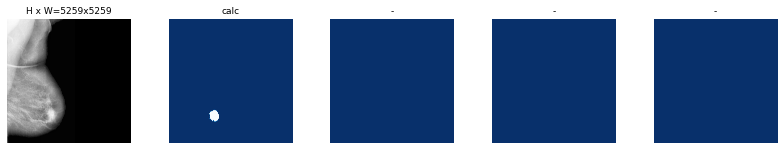

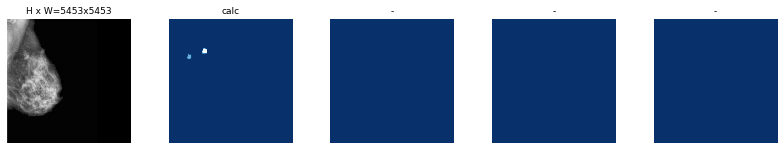

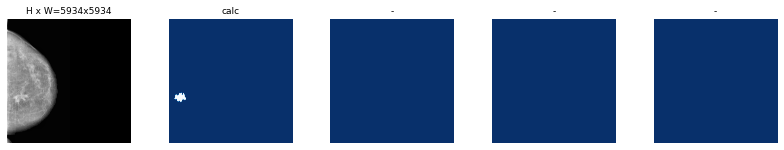

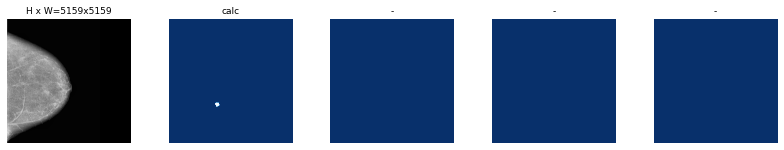

In [7]:
# Load and display random samples
image_ids0 = [re.sub(r'.*\/','',x) for x in glob2.glob(topdir+'train/*')]
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [13]:
# Which weights to start with?
init_with = "coco"

if init_with == "imagenet":
  model.load_weights(model.get_imagenet_weights(), by_names=True)
elif init_with == "coco":
  model.load_weights(COCO_MODEL_PATH, by_name=True,
                     exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                              "mrccn_bbox", "mrcnn_mask"])
elif init_with == "last":
  model.load_weights(model.find_last(), by_name=True)

In [19]:
augmentation = iaa.Sometimes(.667, iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.25.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.25))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255)),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2)),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-180, 180),
        #shear=(-8, 8)
    )
], random_order=True)) # apply augmenters in random order

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [ ]:
epochs = 20
lr = 0.001
model.train(dataset_train, dataset_val, 
            learning_rate=lr, 
            epochs=20, 
            augmentation = augmentation, 
            layers='heads')



Starting at epoch 0. LR=0.001

Checkpoint Path: /home/alangenb_mit_edu/Mask_RCNN/logs/shapes20210510T2053/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
124/500 [======>.......................] - ETA: 3:22 - loss: 2.4374 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.8967 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.7464 - mrcnn_mask_loss: 0.5184

In [35]:
epochs = 20
lrs = np.zeros(epochs)
#lrs[0:2] = 0.002
#lrs[2:5] = 1e-4
#lrs[5:7] = 1e-5
#lrs[7:15] = 5e-6
#lrs[15:epochs] = 1e-6
lrs[0:epochs] = 5e-04
indexes = np.unique(lrs, return_index=True)[1]
unilrs = [lrs[index] for index in sorted(indexes)]

ct = 0
for i in range(len(unilrs)):
    model.train(dataset_train, dataset_val,
                learning_rate=unilrs[i],
                epochs=ct+sum(lrs==unilrs[i]),
                layers='heads')
    ct+=sum(lrs==unilrs[i])


Starting at epoch 0. LR=0.0005

Checkpoint Path: /home/alangenb_mit_edu/Mask_RCNN/logs/shapes20210510T2033/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessi

Epoch 1/20
499/500 [============================>.] - ETA: 0s - loss: 3.4515 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.9333 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.6993 - mrcnn_mask_loss: 0.5920

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


500/500 [==============================] - 502s 1s/step - loss: 3.4500 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 1.9317 - mrcnn_class_loss: 0.1948 - mrcnn_bbox_loss: 0.6995 - mrcnn_mask_loss: 0.5919 - val_loss: 3.0471 - val_rpn_class_loss: 0.0192 - val_rpn_bbox_loss: 1.5462 - val_mrcnn_class_loss: 0.2771 - val_mrcnn_bbox_loss: 0.6240 - val_mrcnn_mask_loss: 0.5808
Epoch 2/20
500/500 [==============================] - 60s 121ms/step - loss: 3.2943 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 1.8143 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.6222 - mrcnn_mask_loss: 0.5420 - val_loss: 2.9932 - val_rpn_class_loss: 0.0181 - val_rpn_bbox_loss: 1.6005 - val_mrcnn_class_loss: 0.2499 - val_mrcnn_bbox_loss: 0.5890 - val_mrcnn_mask_loss: 0.5357
Epoch 3/20
500/500 [==============================] - 61s 122ms/step - loss: 3.1094 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 1.7290 - mrcnn_class_loss: 0.2705 - mrcnn_bbox_loss: 0.5810 - mrcnn_mask_loss: 0.5133 - val_loss: 2.5332 - val_rpn_class_loss: 0.

KeyboardInterrupt: 

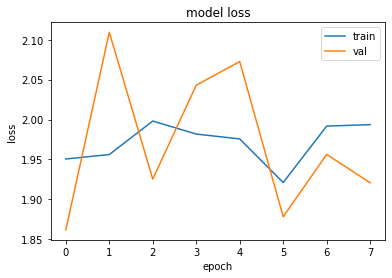

In [12]:
history = model.keras_model.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [19]:
epochs = 20
lrs = np.zeros(epochs)
lrs[0:2] = 0.002
lrs[2:10] = 1e-4
lrs[10:15] = 1e-5
lrs[15:epochs] = 1e-6
indexes = np.unique(lrs, return_index=True)[1]
unilrs = [lrs[index] for index in sorted(indexes)]

for i in range(len(unilrs)):
    model.train(dataset_train, dataset_val,
                learning_rate=unilrs[i],
                epochs=ct+sum(lrs==unilrs[i]),
                layers='all')
    ct+=sum(lrs==unilrs[i])


Starting at epoch 20. LR=5e-06

Checkpoint Path: /home/alangenb_mit_edu/Mask_RCNN/logs/shapes20210510T0311/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D

/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessi

Epoch 21/40
 999/1000 [============================>.] - ETA: 0s - loss: 2.2816 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1937 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.5280 - mrcnn_mask_loss: 0.4639

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 267s 267ms/step - loss: 2.2827 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 1.1944 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.5283 - mrcnn_mask_loss: 0.4639 - val_loss: 2.2864 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 1.0968 - val_mrcnn_class_loss: 0.0873 - val_mrcnn_bbox_loss: 0.5857 - val_mrcnn_mask_loss: 0.5033
Epoch 22/40
1000/1000 [==============================] - 210s 210ms/step - loss: 2.2980 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 1.1665 - mrcnn_class_loss: 0.0887 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4867 - val_loss: 2.3097 - val_rpn_class_loss: 0.0163 - val_rpn_bbox_loss: 1.1441 - val_mrcnn_class_loss: 0.0815 - val_mrcnn_bbox_loss: 0.5655 - val_mrcnn_mask_loss: 0.5022
Epoch 23/40
1000/1000 [==============================] - 210s 210ms/step - loss: 2.2950 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 1.1842 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.5339 - mrcnn_mask_loss: 0.4720 - val_loss: 2.2824 - val_rpn_c

In [17]:
lrs

array([0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002])

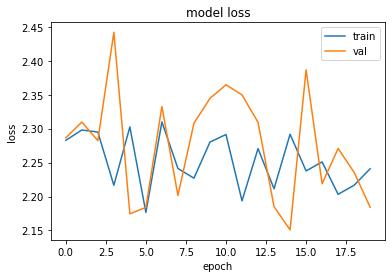

In [20]:
history = model.keras_model.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model_path = os.path.join(MODEL_DIR, "mask_rcnn_"+dtype+"_v1.1.h5")
model.keras_model.save_weights(model_path)

In [ ]:
# DETECTION
class InferenceConfig(ShapesConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

print("Loading weights from ",model_path)
model.load_weights(model_path, by_name=True)


In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
  modellib.load_image_gt(dataset_val, inference_config,
                         image_id, use_mini_mask=False)

log("original_image",original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8,8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))